In [1]:
import rasterio as rio
import numpy as np
import torch
import torchvision
import time
import albumentations as A
import cv2
import matplotlib.pyplot as plt

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
def get_mask_from_path(tiff_path):
        root_path = "/data/spacenet"
        AOI_dirs = ["AOI_1_Rio","AOI_2_Vegas","AOI_3_Paris","AOI_4_Shanghai","AOI_5_Khartoum"]
        tiff_dir = "3band"
        mask_dir = "masks"
        import numpy as np
        import os
        AOI_root = str(tiff_path).split(tiff_dir, maxsplit=1)[0]
        mask_file = 'AOI' + str(tiff_path).split(tiff_dir, maxsplit=1)[1].split('AOI')[-1].split('.tif')[0] + '_mask.npy'
        image_path = os.path.join(AOI_root, mask_dir, mask_file)    

            
        return np.load(image_path)

In [4]:
def get_edges(y_mask_inner):
        import skimage as ski
        import numpy as np

        
        y_mask_edge = np.zeros_like(y_mask_inner)

        padded_mask_inner = np.pad(y_mask_inner, pad_width=1, mode='constant', constant_values=0)
        contours = ski.measure.find_contours(padded_mask_inner, 0.5)
        for contour in contours:
            for point in contour:
                point[0] -= 1
                point[1] -= 1
                if point[0] < 0:
                    point[0] = 0
                if point[1] < 0:
                    point[0] = 0
            if not np.array_equal(contour[0], contour[-1]):
                contour = np.vstack((contour, contour[0]))

            rr, cc = ski.draw.polygon_perimeter(contour[:,0], contour[:,1], y_mask_inner.shape)
            y_mask_edge[rr, cc] = 1
        
        #return ski.morphology.dilation(y_mask_edge)
        return y_mask_edge

In [32]:
def create_weight_map(y_mask_inner, y_mask_edge):
        import cv2
        import numpy as np
        ksize = 7
        sigma = 3
        constant = 256*256

        y_mask_edge_cp = np.copy(y_mask_edge).astype(float)
        y_mask_weight = cv2.GaussianBlur(y_mask_edge_cp, (ksize, ksize), sigma) / constant
        y_mask_weight = y_mask_weight - y_mask_inner

        #Lowest value is zero
        y_mask_weight = np.where(y_mask_weight<0, 0, y_mask_weight)

        return y_mask_weight

5.140606234702947e-06

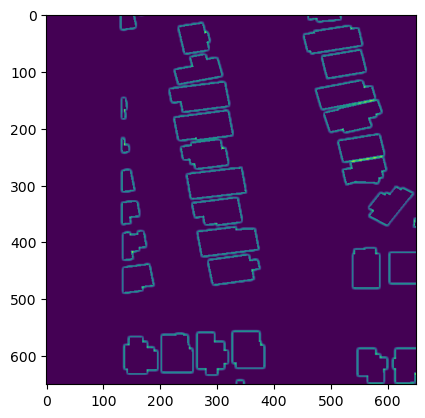

In [31]:
y_mask_inner = get_mask_from_path('/data/spacenet/AOI_2_Vegas/train/3band/RGB-PanSharpen_AOI_2_Vegas_img3.tif')
y_mask_edge = get_edges(y_mask_inner)

y_mask_weight = create_weight_map(y_mask_inner,y_mask_edge)
plt.imshow(y_mask_weight, vmin=0)
y_mask_weight.max()

In [ ]:
y_mask_inner_mask = y_mask_inner.type(torch.long)
logSoftmaxOutput = logSoftmaxOutput.gather(1, y_true.view(batchSize, 1, imgSize, imgSize))